# JaX Flax --> ONNX

This notebook converts brax MLP networks to an ONNX checkpoint.

In [1]:
ckpt_path = "/home/xinchen/Dev/philab-mujoco/logs/TronPfJoystick-20250728-013742"
env_name = "TronPfJoystick"

# ckpt_path = "/home/xinchen/Dev/philab-mujoco/logs/TronSfJoystick-20250722-055050"
# env_name = "TronSfJoystick"

In [2]:
import os

os.environ["JAX_DEFAULT_MATMUL_PRECISION"] = "high"
os.environ["PYGLFW_LIBRARY_VARIANT"] = "x11"


In [3]:
from brax.training.agents.ppo import networks as ppo_networks
from philab_mujoco import locomotion
from philab_mujoco import train_params
import functools
import pickle
import jax.numpy as jp
import jax
import tf2onnx
import tensorflow as tf
from keras import layers
import onnxruntime as rt
from brax.training.acme import running_statistics

2025-07-28 04:01:04.821281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753693264.828905  163675 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753693264.831612  163675 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753693264.838253  163675 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753693264.838270  163675 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753693264.838271  163675 computation_placer.cc:177] computation placer alr

In [4]:
tf.config.set_visible_devices([], 'GPU')

W0000 00:00:1753693266.475947  163675 gpu_device.cc:2430] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [5]:
# ppo_params = locomotion_params.brax_ppo_config(env_name)
ppo_params = train_params.brax_ppo_config(env_name)

In [6]:
def identity_observation_preprocessor(observation, preprocessor_params):
  del preprocessor_params
  return observation

network_factory=functools.partial(
  ppo_networks.make_ppo_networks,
  **ppo_params.network_factory,
  # We need to explicitly call the normalization function here since only the brax
  # PPO train.py script creates it if normalize_observations is True.
  preprocess_observations_fn=running_statistics.normalize,
)

In [7]:
# env_cfg = locomotion.get_default_config(env_name)
# env = locomotion.load(env_name, config=env_cfg)
env_cfg = locomotion.get_default_config(env_name)
env = locomotion.load(env_name, config=env_cfg)

In [8]:
obs_size = env.observation_size
act_size = env.action_size
# print(obs_size, act_size)

print(f"Observation size: {obs_size}")
print(f"Action size: {act_size}")

Observation size: {'privileged_state': (76,), 'state': (31,), 'state_history': (310,)}
Action size: 6


In [9]:
ppo_network = network_factory(obs_size, act_size)

In [10]:
ckpt_path = ckpt_path + "/params.pkl"

with open(ckpt_path, 'rb') as f:
    params = pickle.load(f)
print(params.keys())

# Save ONNX to the checkpoint directory
output_path = os.path.join(os.path.dirname(ckpt_path), "policy.onnx")

dict_keys(['normalizer_params', 'policy_params', 'value_params'])


In [11]:
params = (params["normalizer_params"], params["policy_params"])

In [12]:
make_inference_fn = ppo_networks.make_inference_fn(ppo_network)
inference_fn = make_inference_fn(params, deterministic=True)

In [13]:
class EMLP(tf.keras.Model):
    def __init__(
        self,
        layer_sizes,
        encoder_layer_sizes,
        activation=tf.nn.relu,
        kernel_init="lecun_uniform",
        activate_final=False,
        bias=True,
        layer_norm=False,
        mean_std=None,
        encoder_mean_std=None,
    ):
        super().__init__()

        self.layer_sizes = layer_sizes
        self.encoder_layer_sizes = encoder_layer_sizes
        self.activation = activation
        self.kernel_init = kernel_init
        self.activate_final = activate_final
        self.bias = bias
        self.layer_norm = layer_norm

        if mean_std is not None:
            self.mean = tf.Variable(mean_std[0], trainable=False, dtype=tf.float32)
            self.std = tf.Variable(mean_std[1], trainable=False, dtype=tf.float32)
        else:
            self.mean = None
            self.std = None

        if encoder_mean_std is not None:
            self.encoder_mean = tf.Variable(encoder_mean_std[0], trainable=False, dtype=tf.float32)
            self.encoder_std = tf.Variable(encoder_mean_std[1], trainable=False, dtype=tf.float32)
        else:
            self.encoder_mean = None
            self.encoder_std = None

        self.mlp_block = tf.keras.Sequential(name="MLP_1")
        for i, size in enumerate(self.layer_sizes):
            dense_layer = layers.Dense(
                size,
                activation=self.activation,
                kernel_initializer=self.kernel_init,
                name=f"hidden_{i}",
                use_bias=self.bias,
            )
            self.mlp_block.add(dense_layer)
            if self.layer_norm:
                self.mlp_block.add(layers.LayerNormalization(name=f"layer_norm_{i}"))

        self.encoder_block = tf.keras.Sequential(name="MLP_0")
        for i, size in enumerate(self.encoder_layer_sizes):
            dense_layer = layers.Dense(
                size,
                activation=self.activation,
                kernel_initializer=self.kernel_init,
                name=f"hidden_{i}",
                use_bias=self.bias,
            )
            self.encoder_block.add(dense_layer)
            if self.layer_norm:
                self.encoder_block.add(layers.LayerNormalization(name=f"layer_norm_{i}"))

        if not self.activate_final and self.mlp_block.layers:
            if hasattr(self.mlp_block.layers[-1], 'activation') and self.mlp_block.layers[-1].activation is not None:
                self.mlp_block.layers[-1].activation = None

        # if not self.activate_final and self.encoder_block.layers:
        #     if hasattr(self.encoder_block.layers[-1], 'activation') and self.encoder_block.layers[-1].activation is not None:
        #         self.encoder_block.layers[-1].activation = None

        self.submodules = [self.encoder_block, self.mlp_block]

    def call(self, inputs):
        if isinstance(inputs, list):
            main_input, encoder_input = inputs
        else:
            raise ValueError("Input should be a list containing main input and encoder input.")

        if self.mean is not None and self.std is not None:
            print(self.mean.shape, self.std.shape)
            main_input = (main_input - self.mean) / self.std

        if self.encoder_mean is not None and self.encoder_std is not None:
            print(self.encoder_mean.shape, self.encoder_std.shape)
            encoder_input = (encoder_input - self.encoder_mean) / self.encoder_std

        encoded = self.encoder_block(encoder_input)

        logits = self.mlp_block(
            tf.concat([main_input, encoded], axis=-1)
        )
        loc, _ = tf.split(logits, 2, axis=-1)
        return tf.tanh(loc)

def make_policy_network(
    param_size,
    mean_std,
    encoder_mean_std,
    hidden_layer_sizes,
    encoder_hidden_layer_sizes,
    activation=tf.nn.relu,
    kernel_init="lecun_uniform",
    layer_norm=False,
):
    policy_network = EMLP(
        layer_sizes=list(hidden_layer_sizes) + [param_size],
        encoder_layer_sizes=list(encoder_hidden_layer_sizes),
        activation=activation,
        kernel_init=kernel_init,
        layer_norm=layer_norm,
        mean_std=mean_std,
        encoder_mean_std=encoder_mean_std,
    )
    return policy_network

In [14]:
mean = params[0].mean["state"]
std = params[0].std["state"]
mean_std = (tf.convert_to_tensor(mean), tf.convert_to_tensor(std))

encoder_mean = params[0].mean["state_history"]
encoder_std = params[0].std["state_history"]
encoder_mean_std = (tf.convert_to_tensor(encoder_mean), tf.convert_to_tensor(encoder_std))

tf_policy_network = make_policy_network(
    param_size=act_size * 2,
    mean_std=mean_std,
    encoder_mean_std=encoder_mean_std,
    hidden_layer_sizes=ppo_params.network_factory.policy_hidden_layer_sizes,
    encoder_hidden_layer_sizes=ppo_params.network_factory.encoder_hidden_layer_sizes,
    activation=tf.nn.swish,
)

In [15]:
example_input = tf.zeros((1, obs_size["state"][0]))
example_encoder_input = tf.zeros((1, obs_size["state_history"][0]))
example_output = tf_policy_network([example_input, example_encoder_input])
print(example_output.shape)

(31,) (31,)
(310,) (310,)
(31,) (31,)
(310,) (310,)
(1, 6)


In [16]:
import numpy as np
import tensorflow as tf

def transfer_weights(jax_params, tf_model):
    """
    Transfer weights from a JAX parameter dictionary to the TensorFlow model.

    Parameters:
    - jax_params: dict
      Nested dictionary with structure {block_name: {layer_name: {params}}}.
      For example:
      {
        'CNN_0': {
          'Conv_0': {'kernel': np.ndarray},
          'Conv_1': {'kernel': np.ndarray},
          'Conv_2': {'kernel': np.ndarray},
        },
        'MLP_0': {
          'hidden_0': {'kernel': np.ndarray, 'bias': np.ndarray},
          'hidden_1': {'kernel': np.ndarray, 'bias': np.ndarray},
          'hidden_2': {'kernel': np.ndarray, 'bias': np.ndarray},
        }
      }

    - tf_model: tf.keras.Model
      An instance of the adapted VisionMLP model containing named submodules and layers.
    """
    mlp0_params = jax_params.get('MLP_0', {}) # encoder
    mlp1_params = jax_params.get('MLP_1', {}) # policy

    print(f"Transferring encoder weights:")
    for layer_name, layer_params in mlp0_params.items():
        try:
            tf_layer = tf_model.get_layer("MLP_0").get_layer(name=layer_name)
        except ValueError:
            print(f"Layer {layer_name} not found in TensorFlow model.")
            continue
        if isinstance(tf_layer, tf.keras.layers.Dense):
            kernel = np.array(layer_params['kernel'])
            bias = np.array(layer_params['bias'])
            print(f"Transferring Dense layer {layer_name}, kernel shape {kernel.shape}, bias shape {bias.shape}")
            tf_layer.set_weights([kernel, bias])
        else:
            print(f"Unhandled layer type in {layer_name}: {type(tf_layer)}")

    print(f"Transferring policy weights:")
    for layer_name, layer_params in mlp1_params.items():
        try:
            tf_layer = tf_model.get_layer("MLP_1").get_layer(name=layer_name)
        except ValueError:
            print(f"Layer {layer_name} not found in TensorFlow model.")
            continue
        if isinstance(tf_layer, tf.keras.layers.Dense):
            kernel = np.array(layer_params['kernel'])
            bias = np.array(layer_params['bias'])
            print(f"Transferring Dense layer {layer_name}, kernel shape {kernel.shape}, bias shape {bias.shape}")
            tf_layer.set_weights([kernel, bias])
        else:
            print(f"Unhandled layer type in {layer_name}: {type(tf_layer)}")

    print("Weights transferred successfully.")

In [17]:
transfer_weights(params[1]['params'], tf_policy_network)

Transferring encoder weights:
Transferring Dense layer hidden_0, kernel shape (310, 128), bias shape (128,)
Transferring Dense layer hidden_1, kernel shape (128, 32), bias shape (32,)
Transferring Dense layer hidden_2, kernel shape (32, 8), bias shape (8,)
Transferring policy weights:
Transferring Dense layer hidden_0, kernel shape (39, 512), bias shape (512,)
Transferring Dense layer hidden_1, kernel shape (512, 256), bias shape (256,)
Transferring Dense layer hidden_2, kernel shape (256, 128), bias shape (128,)
Transferring Dense layer hidden_3, kernel shape (128, 12), bias shape (12,)
Weights transferred successfully.


In [18]:
obs_test = np.ones((1, obs_size["state"][0]), dtype=np.float32) * .1
obs_history_test = np.ones((1, obs_size["state_history"][0]), dtype=np.float32) * .1

In [19]:
# Example inputs for the model
test_input = [obs_test, obs_history_test]

# Define the TensorFlow input signature
spec = [tf.TensorSpec(shape=(1, obs_size["state"][0]), dtype=tf.float32, name="obs"),
        tf.TensorSpec(shape=(1, obs_size["state_history"][0]), dtype=tf.float32, name="obs_history")]

tensorflow_pred = tf_policy_network(test_input)[0]
# Build the model by calling it with example data
print(f"Tensorflow prediction: {tensorflow_pred}")

tf_policy_network.output_names = ['action']

# opset 11 matches isaac lab.
model_proto, _ = tf2onnx.convert.from_keras(tf_policy_network, input_signature=spec, opset=11, output_path=output_path)

# Run inference with ONNX Runtime
output_names = ['action']
providers = ['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers=providers)

(31,) (31,)
(310,) (310,)
Tensorflow prediction: [-0.15433222  0.14165966  0.4075409   0.07962049  0.15174595  0.6009094 ]
(31,) (31,)
(310,) (310,)


I0000 00:00:1753693268.887170  163675 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1753693268.887298  163675 single_machine.cc:374] Starting new session
W0000 00:00:1753693268.889796  163675 gpu_device.cc:2430] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1753693268.895194  163675 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1818 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5080, pci bus id: 0000:01:00.0, compute capability: 12.0
I0000 00:00:1753693268.962492  163675 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1753693268.962618  163675 single_machine.cc:374] Starting new session
W0000 00:00:1753693268.965248  163675 gpu_device.cc:2430] TensorFlow was not built with CUDA kernel binaries compatib

In [20]:
onnx_input = {
    'obs': obs_test,
    'obs_history': obs_history_test,
}
# Prepare inputs for ONNX Runtime
onnx_pred = m.run(output_names, onnx_input)[0][0]

print("ONNX prediction:", onnx_pred)

ONNX prediction: [-0.15433191  0.14165932  0.40754128  0.07962064  0.15174563  0.600909  ]


In [21]:
test_input = {
    'state': jp.array(obs_test),
    'state_history': jp.array(obs_history_test),
    'privileged_state': jp.zeros(obs_size["privileged_state"])
}
jax_pred, _ = inference_fn(test_input, jax.random.PRNGKey(0))
jax_pred = jax_pred[0]
print(jax_pred)

[-0.15433234  0.14165986  0.4075419   0.07962012  0.15174612  0.60091   ]


(6,)
(6,)
(6,)


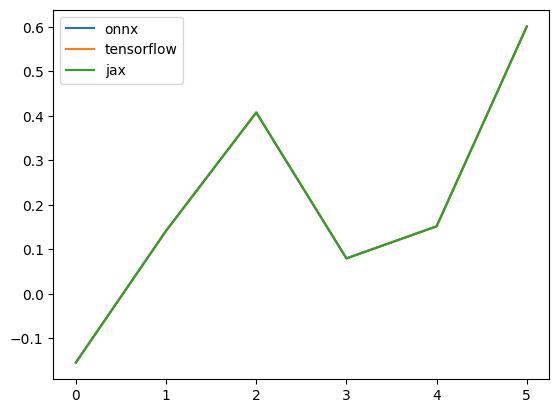

In [22]:
import matplotlib.pyplot as plt
print(onnx_pred.shape)
print(tensorflow_pred.shape)
print(jax_pred.shape)
plt.plot(onnx_pred, label='onnx')
plt.plot(tensorflow_pred, label='tensorflow')
plt.plot(jax_pred, label='jax')
plt.legend()
plt.show()

In [23]:
import onnx

# Extract checkpoint name from path
checkpoint_name = os.path.basename(os.path.dirname(ckpt_path))
print(f"Adding model name: {checkpoint_name}")

# Load the ONNX model
model = onnx.load(output_path)

# Add the checkpoint name as model metadata
model.metadata_props.append(onnx.StringStringEntryProto(key="name", value=checkpoint_name))
model.doc_string = checkpoint_name

# Save the updated model
onnx.save(model, output_path)
print(f"Model name '{checkpoint_name}' added to ONNX file")

Adding model name: TronPfJoystick-20250728-013742
Model name 'TronPfJoystick-20250728-013742' added to ONNX file
